In [1]:
import numpy as np
import pandas as pd
from sklearn.base import clone 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold, KFold, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_regression
import matplotlib.pyplot as plt
import time
from glob import glob
import json
import sys
import os
# make paths above 'notebooks/' visible for local imports.
# +----------------------------------------------------------------------------+
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing import GatherFeatureDatasets
from src.utils import CrossValidation
from src.feature_selection import CustomRFECV
from src.feature_selection import IntrinsicFeatureSelection as ifs
from src.plotting import plot_pairwise_correlations
from src.utils import NumpyEncoder


# Load RFECV outputs

In [2]:
datadir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/feature_selection/experiment_YUF'

In [3]:
rfecv_pref = os.path.join(datadir, "rfecv*")
rfecv_results_dicts = {}
for file in glob(rfecv_pref):
    name = os.path.basename(file).split('.json')[0]
    print(name)
    with open(file) as fp:
        rfecv_results_dicts[name] = json.load(fp)

rfecv.absDist.estimators.default
rfecv.relDist.estimators.default
rfecv.relDist.estimators.tuned
rfecv.absDist.estimators.tuned
rfecv.relDist.trees
rfecv.absDist.trees


# Load RFE results for full training sets

In [4]:
rfe_pref = os.path.join(datadir, "rfe.*")
rfe_results_dicts = {}
for file in glob(rfe_pref):
    name = os.path.basename(file).split('.json')[0]
    print(name)
    with open(file) as fp:
        rfe_results_dicts[name] = json.load(fp)

rfe.full.absDist.estimators.default
rfe.full.absDist.estimators.tuned
rfe.full.relDist.estimators.default
rfe.full.relDist.estimators.tuned
rfe.full.absDist.trees
rfe.full.relDist.trees


# Plots for RFECV

In [5]:
SMALL_SIZE=8
MEDIUM_SIZE=9
LARGE_SIZE=9
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title
plt.rc('figure', labelsize=MEDIUM_SIZE)

In [6]:
best_N_label = '$\it{n}$-max'
oste_N_label = '$\it{n}$-min'

In [7]:
def plot_R2_vs_N(results_dict, title=None, n_cols = 2, savefigname=None):
    n_dsets = len(results_dict.keys())
    n_rows = int(np.ceil(n_dsets/n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, constrained_layout=True, figsize=(n_cols*3, n_rows*3))
    axes = axes.flatten()
    for i, key in enumerate(results_dict.keys()):
        model_results = results_dict[key]
        full_score_array = model_results['N_scores']
        N_avgs = np.average(full_score_array, axis=0)
        N_min = np.min(full_score_array, axis=0)
        N_max = np.max(full_score_array, axis=0)
        N_feats_to_use = model_results['best_N']
        oste_N = model_results['oste_N']
        x = np.arange(N_avgs.shape[0])+1
        axes[i].fill_between(x, N_min, N_max, alpha=0.5, label='CV range')
        axes[i].scatter(x, N_avgs, color='C0', label='CV avg.')
        axes[i].scatter(N_feats_to_use, N_avgs[N_feats_to_use-1], marker="s", color='r', label=best_N_label)
        axes[i].scatter(oste_N, N_avgs[oste_N-1], marker="x", color='purple', label=oste_N_label)    
        axes[i].set_title(key, fontsize=8)
        axes[i].grid(axis='y')
        axes[i].set_ylim([0, 1.0])
        if i %  n_cols != 0:
            axes[i].set_yticklabels([])

    for i in np.arange(n_cols*(n_rows-1)):
        axes[i].set_xticklabels([])

    if n_cols * n_rows > n_dsets:
        for i in np.arange(n_dsets, n_rows*n_cols):
            axes[i].axis('off')

    axes[0].legend(loc='lower right')
    splabels = ['(a)', '(b)', '(c)', '(d)']
    for i, ax in enumerate(axes):
        ax.text(0, 1.02, splabels[i], transform=ax.transAxes)
    fig.supxlabel("N features")
    fig.supylabel("$R^2$")
    fig.suptitle(title, fontsize=9)
    if savefigname is not None:
        fig.savefig(savefigname, dpi=300)

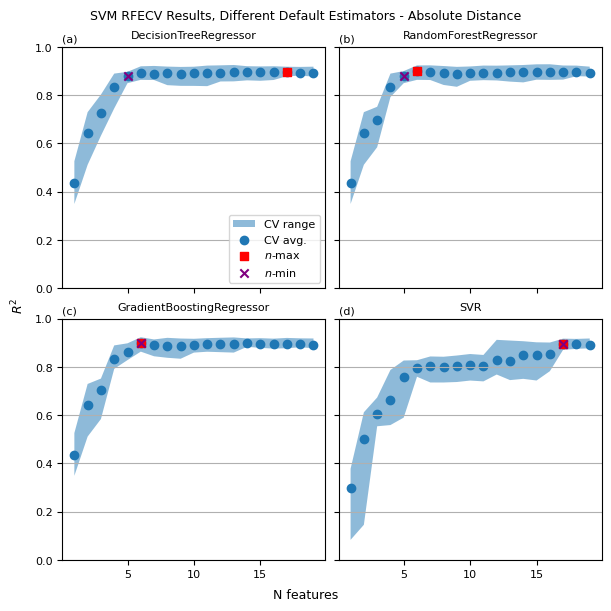

In [8]:
plot_R2_vs_N(rfecv_results_dicts['rfecv.absDist.estimators.default'], 
             title = 'SVM RFECV Results, Different Default Estimators - Absolute Distance')

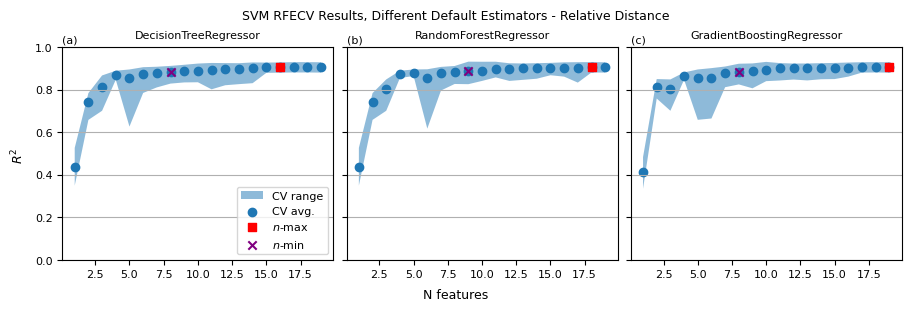

In [9]:
plot_R2_vs_N(rfecv_results_dicts['rfecv.relDist.estimators.default'], 
             title = 'SVM RFECV Results, Different Default Estimators - Relative Distance',
             n_cols=3,
             savefigname='../figures/rfeSelection_r2VN_defaults.png')

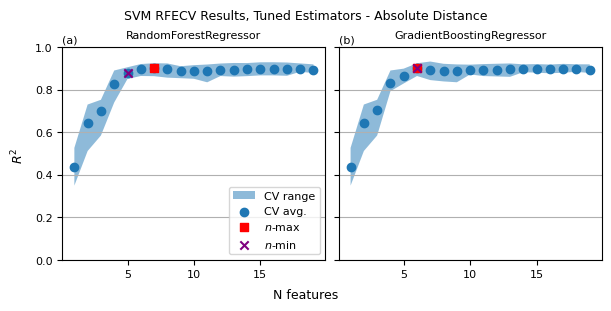

In [10]:
plot_R2_vs_N(rfecv_results_dicts['rfecv.absDist.estimators.tuned'], 
             title = 'SVM RFECV Results, Tuned Estimators - Absolute Distance')

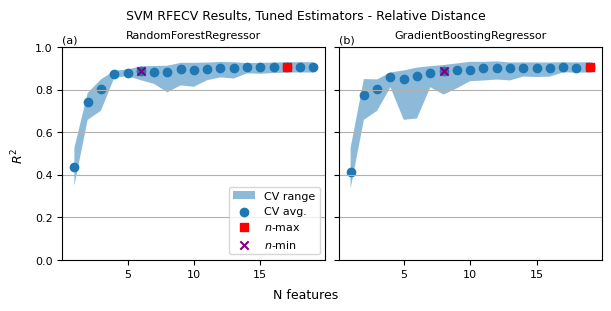

In [11]:
plot_R2_vs_N(rfecv_results_dicts['rfecv.relDist.estimators.tuned'], 
             title = 'SVM RFECV Results, Tuned Estimators - Relative Distance')

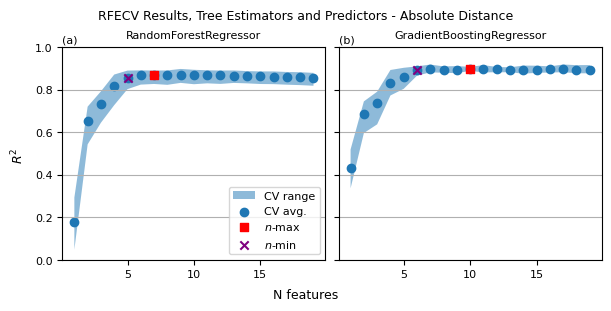

In [12]:
plot_R2_vs_N(rfecv_results_dicts['rfecv.absDist.trees'], 
             title = 'RFECV Results, Tree Estimators and Predictors - Absolute Distance')

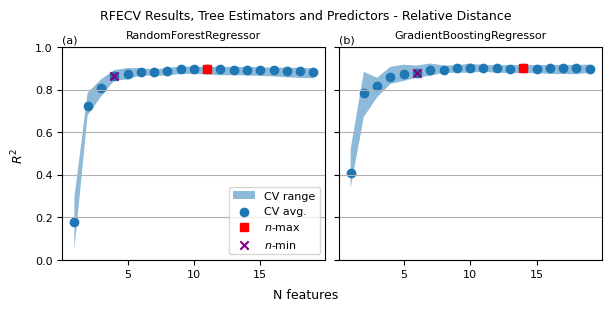

In [13]:
plot_R2_vs_N(rfecv_results_dicts['rfecv.relDist.trees'], 
             title = 'RFECV Results, Tree Estimators and Predictors - Relative Distance')

In [14]:
rfecv_results_dicts.keys()

dict_keys(['rfecv.absDist.estimators.default', 'rfecv.relDist.estimators.default', 'rfecv.relDist.estimators.tuned', 'rfecv.absDist.estimators.tuned', 'rfecv.relDist.trees', 'rfecv.absDist.trees'])

In [15]:
short_model_names = {'DecisionTreeRegressor': 'DT',
                     'RandomForestRegressor': 'RF',
                     'GradientBoostingRegressor': 'GBT',
                     'SVR':'SVR'}

short_titles = {'rfecv.absDist.estimators.default': 'SVM, Default - Abs.', 
                'rfecv.relDist.estimators.default': 'SVM, Default - Rel.', 
                'rfecv.relDist.estimators.tuned': 'SVM, Tuned - Rel.', 
                'rfecv.absDist.estimators.tuned': 'SVM, Tuned - Abs.', 
                'rfecv.relDist.trees': 'Trees, Tuned - Rel.', 
                'rfecv.absDist.trees': 'Trees, Tuned - Abs.'
}
outer_keys_order = ['rfecv.relDist.estimators.default',
                    'rfecv.absDist.estimators.default', 
                    'rfecv.relDist.estimators.tuned',
                    'rfecv.absDist.estimators.tuned', 
                    'rfecv.relDist.trees',
                    'rfecv.absDist.trees']


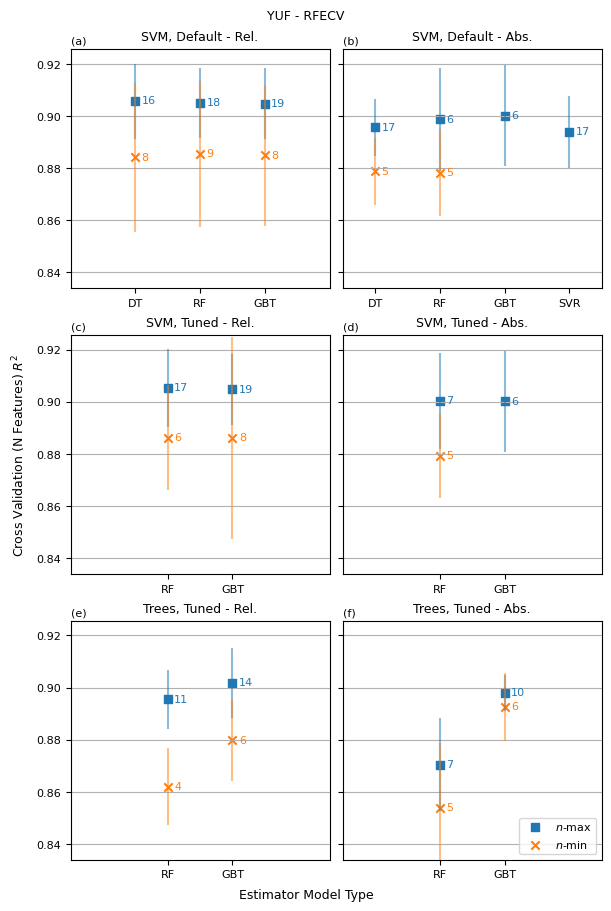

In [16]:
n_cols = 2
best_sym = 's'
oste_sym = 'x'
best_color = 'C0'
oste_color = 'C1'
n_outer_dsets = len(rfecv_results_dicts.keys())
n_rows = int(np.ceil(n_outer_dsets/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, constrained_layout=True, figsize=(n_cols*3, n_rows*3))
axes = axes.flatten()

max_n_inner_dset = 0
max_score = 0
min_score = 2
for outer_key in outer_keys_order:
    outer_dict = rfecv_results_dicts[outer_key]
    n_inner_dsets = len(outer_dict.keys())
    if n_inner_dsets > max_n_inner_dset:
            max_n_inner_dset = n_inner_dsets
    for inner_key in outer_dict.keys():
        inner_dict = outer_dict[inner_key]
        if inner_dict['best_N_score'] > max_score:
             max_score = inner_dict['best_N_score'] 
        elif inner_dict['oste_N_score'] < min_score:
             min_score = inner_dict['oste_N_score']
        
for outer_k_ind, outer_key in enumerate(outer_keys_order):
    outer_dict = rfecv_results_dicts[outer_key]
    ax = axes[outer_k_ind]
    n_inner_dsets = len(outer_dict.keys())
    xtick_labels = []
    for inner_k_ind, inner_key in enumerate(outer_dict.keys()):
        label_pref = ""
        if inner_k_ind > 0:
             label_pref ="_"
        xtick_labels.append(short_model_names[inner_key])
        results = outer_dict[inner_key]
        best_N = results['best_N']
        best_N_mean = results['best_N_score']
        best_N_std = np.std(np.array(results['N_scores'])[:, best_N-1])
        ax.scatter(inner_k_ind, best_N_mean, marker=best_sym, color=best_color, label = label_pref+best_N_label)
        ax.vlines(inner_k_ind, best_N_mean-best_N_std, best_N_mean+best_N_std, color=best_color, alpha=0.5)
        ax.text(inner_k_ind+0.1, best_N_mean-0.001, best_N, color=best_color)
        oste_N = results['oste_N']
        if best_N != oste_N:
            oste_N_mean = results['oste_N_score']
            oste_N_std = np.std(np.array(results['N_scores'])[:, oste_N-1])
            ax.scatter(inner_k_ind, oste_N_mean, marker=oste_sym, color=oste_color, label=label_pref+oste_N_label)
            ax.vlines(inner_k_ind, oste_N_mean-oste_N_std, oste_N_mean+oste_N_std, color=oste_color, alpha=0.5)
            ax.text(inner_k_ind+0.1, oste_N_mean-0.001, oste_N, color=oste_color)

    ax.set_ylim([min_score-0.02, max_score+0.02])
    if outer_k_ind % n_cols > 0:
         ax.set_yticklabels([])
    ax.set_xticks(np.arange(n_inner_dsets), 
            xtick_labels,
            rotation=0)
    offset = (max_n_inner_dset - n_inner_dsets)
    if offset > 0:
         offset /= 2
    ax.set_xlim([-offset-0.5, (n_inner_dsets-1)+offset+0.5])
    ax.set_title(short_titles[outer_key])
    ax.grid(axis='y')

splabels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
for i, ax in enumerate(axes):
     ax.text(0, 1.02, splabels[i], transform=ax.transAxes)
ax.legend(loc='lower right')
fig.supxlabel("Estimator Model Type")
fig.supylabel("Cross Validation (N Features) $R^2$")
fig.suptitle("YUF - RFECV")
fig.savefig('../figures/rfeSelection_rfecvSummary.png', dpi=300)

# Plots for full train RFE

In [17]:
best_N_label = '$\it{n}$-max'
oste_N_label = '$\it{n}$-min'

In [18]:
rfe_results_dicts.keys()

dict_keys(['rfe.full.absDist.estimators.default', 'rfe.full.absDist.estimators.tuned', 'rfe.full.relDist.estimators.default', 'rfe.full.relDist.estimators.tuned', 'rfe.full.absDist.trees', 'rfe.full.relDist.trees'])

In [19]:
rfe_results_dicts['rfe.full.absDist.estimators.default'].keys()

dict_keys(['DecisionTreeRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor', 'SVR'])

In [20]:
rfe_results_dicts['rfe.full.absDist.estimators.default']['RandomForestRegressor'].keys()

dict_keys(['best', 'oste'])

In [21]:
rfe_results_dicts['rfe.full.absDist.estimators.default']['RandomForestRegressor']['oste']

{'selected_feature_inds': [18, 19, 24, 43, 44],
 'pred_cv_mean': 0.877057462443126,
 'pred_cv_std': 0.01693498414601668,
 'pred_cv_params': {'m__C': 10, 'm__gamma': 0.1}}

In [22]:
short_model_names = {'DecisionTreeRegressor': 'DT',
                     'RandomForestRegressor': 'RF',
                     'GradientBoostingRegressor': 'GBT',
                     'SVR':'SVR'}

short_titles = {'rfe.full.absDist.estimators.default': 'SVM, Default - Abs.', 
                'rfe.full.relDist.estimators.default': 'SVM, Default - Rel.', 
                'rfe.full.relDist.estimators.tuned': 'SVM, Tuned - Rel.', 
                'rfe.full.absDist.estimators.tuned': 'SVM, Tuned - Abs.', 
                'rfe.full.relDist.trees': 'Trees, Tuned - Rel.', 
                'rfe.full.absDist.trees': 'Trees, Tuned - Abs.'
}
outer_keys_order = ['rfe.full.relDist.estimators.default',
                    'rfe.full.absDist.estimators.default', 
                    'rfe.full.relDist.estimators.tuned',
                    'rfe.full.absDist.estimators.tuned', 
                    'rfe.full.relDist.trees',
                    'rfe.full.absDist.trees']

rfe.full.absDist.estimators.default DecisionTreeRegressor 0.8761004636359327
rfe.full.relDist.trees RandomForestRegressor 0.8622401376604006
rfe.full.absDist.trees RandomForestRegressor 0.8569529184701


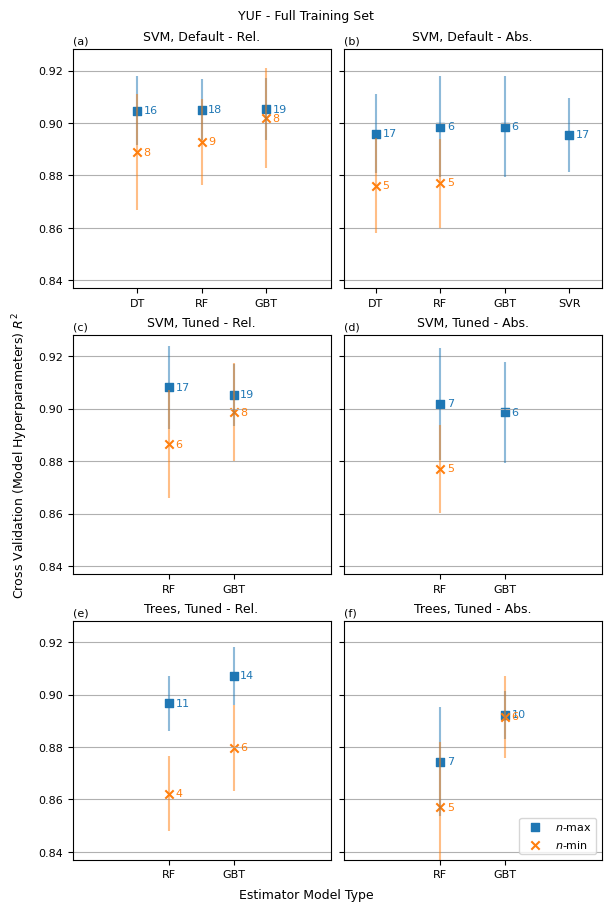

In [23]:
n_cols = 2
best_sym = 's'
oste_sym = 'x'
best_color = 'C0'
oste_color = 'C1'
n_outer_dsets = len(rfe_results_dicts.keys())
n_rows = int(np.ceil(n_outer_dsets/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, constrained_layout=True, figsize=(n_cols*3, n_rows*3))
axes = axes.flatten()

max_n_inner_dset = 0
max_score = 0
min_score = 2
for outer_key in outer_keys_order:
    outer_dict = rfe_results_dicts[outer_key]
    n_inner_dsets = len(outer_dict.keys())
    if n_inner_dsets > max_n_inner_dset:
            max_n_inner_dset = n_inner_dsets
    for inner_key in outer_dict.keys():
        inner_dict = outer_dict[inner_key]
        if inner_dict['best']['pred_cv_mean'] > max_score:
             max_score = inner_dict['best']['pred_cv_mean']
        elif inner_dict['oste'] is not None and inner_dict['oste']['pred_cv_mean'] < min_score:
             min_score = inner_dict['oste']['pred_cv_mean']
             print(outer_key, inner_key, min_score)
        
for outer_k_ind, outer_key in enumerate(outer_keys_order):
    outer_dict = rfe_results_dicts[outer_key]
    ax = axes[outer_k_ind]
    n_inner_dsets = len(outer_dict.keys())
    xtick_labels = []
    for inner_k_ind, inner_key in enumerate(outer_dict.keys()):
        label_pref = ""
        if inner_k_ind > 0:
             label_pref ="_"
        xtick_labels.append(short_model_names[inner_key])
        results = outer_dict[inner_key]
        best_N = len(results['best']['selected_feature_inds'])
        best_N_mean = results['best']['pred_cv_mean']
        best_N_std = results['best']['pred_cv_std']
        ax.scatter(inner_k_ind, best_N_mean, marker=best_sym, color=best_color, label = label_pref+best_N_label)
        ax.vlines(inner_k_ind, best_N_mean-best_N_std, best_N_mean+best_N_std, color=best_color, alpha=0.5)
        ax.text(inner_k_ind+0.1, best_N_mean-0.001, best_N, color=best_color)
        oste = results['oste']
        if oste is not None:
            oste_N = len(results['oste']['selected_feature_inds'])
            oste_N_mean = results['oste']['pred_cv_mean']
            oste_N_std = results['oste']['pred_cv_std']
            ax.scatter(inner_k_ind, oste_N_mean, marker=oste_sym, color=oste_color, label=label_pref+oste_N_label)
            ax.vlines(inner_k_ind, oste_N_mean-oste_N_std, oste_N_mean+oste_N_std, color=oste_color, alpha=0.5)
            ax.text(inner_k_ind+0.1, oste_N_mean-0.001, oste_N, color=oste_color)

    ax.set_ylim([min_score-0.02, max_score+0.02])
    if outer_k_ind % n_cols > 0:
         ax.set_yticklabels([])
    ax.set_xticks(np.arange(n_inner_dsets), 
            xtick_labels,
            rotation=0)
    offset = (max_n_inner_dset - n_inner_dsets)
    if offset > 0:
         offset /= 2
    ax.set_xlim([-offset-0.5, (n_inner_dsets-1)+offset+0.5])
    ax.set_title(short_titles[outer_key])
    ax.grid(axis='y')
ax.legend(loc='lower right')

splabels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
for i, ax in enumerate(axes):
     ax.text(0, 1.02, splabels[i], transform=ax.transAxes)
     
fig.supxlabel("Estimator Model Type")
fig.supylabel("Cross Validation (Model Hyperparameters) $R^2$")
fig.suptitle("YUF - Full Training Set")
fig.savefig('../figures/rfeSelection_rfefullSummary.png', dpi=300)